Importing Packages

In [197]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import f1_score

Loading Data

In [198]:
kabikit = pd.read_csv("data\\kabitakitchen.csv", encoding='unicode-escape')
nisha = pd.read_csv("data\\Nishafin.csv")

Pre-Processing

In [201]:
def preprocess_input(text):
    # remove smiley if any
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    hin_stop = []
    with open("data\\stop_hinglish.txt","r") as rd:
        for line in rd.readlines():
            hin_stop.append(line[:-1])
            
    text = emoji_pattern.sub(r'', text)
    prep_text = text.lower()
    
    #remove hyperlinks
    prep_text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', prep_text)
    #removing text inside ()
    prep_text = re.sub(r'\([^)]*\)', '', prep_text)
    #removing text inside []
    prep_text = re.sub(r'\{[^)]*\}', '', prep_text)
    #fetching alphabetic characters
    prep_text = re.sub("[^a-zA-Z]", " ", prep_text)
    #removing stop words
    stopWEn = stopwords.words('english')
    tokens = [w for w in prep_text.split() if not w in stopWEn] 
    fin_words = [w for w in tokens if not w in hin_stop]
    #return " ".join(prep_text.split())
    return (" ".join(fin_words)).strip()

In [202]:
kabikit['commentText'] = kabikit['commentText'].astype(str)
kabikit['Labels'] = kabikit['Labels'].astype(int)
kabikit['Labels'] = kabikit['Labels'].astype(int)
kabikit['Labels'] = kabikit['Labels'].apply(lambda x : x-1)
kabikit['prep_text'] = kabikit['commentText'].apply(preprocess_input)

,id,commentText,Labels,Encoded,prep_text
0,Ugy_CBm-_CKA3YqrzcB4AaABAg,Pudina ptta nhi dalu to,6,1,pudina ptta dalu
1,Ugy9mx9nuTWJu4dRac14AaABAg,Chiken kacha tu ni rhy ga sis,6,1,chiken kacha ni rhy ga sis
2,Ugz8T2MKLYucL3dM9nh4AaABAg,"Hello mam, I love your all recipes.... ðð...",3,0,mam love recipes ingredients easily available ...
3,Ugx_1cCjRbCaDgL0FLF4AaABAg,Its awesome recipe plzz make handi chicken in ...,1,0,awesome recipe plzz make handi chicken handi
4,UgzLhKVAJ6NN3nZXyjN4AaABAg,Yeh jo measurement hai.........kitne logon ke ...,6,1,measurement


In [203]:
nisha['commentText'] = nisha['commentText'].astype(str)
nisha['Labels'] = nisha['Labels'].astype(int)
nisha['Labels'] = nisha['Labels'].astype(int)
nisha['Labels'] = nisha['Labels'].apply(lambda x : x-1)
nisha['prep_text'] = nisha['commentText'].apply(preprocess_input)

,id,commentText,Labels,Encoded,prep_text
0,Ugz7LQV0ZWpuNnjBaxJ4AaABAg,i love potato ke prathe,1,0,love potato prathe
1,UgxvWJ_kJL2nePTkg2N4AaABAg,Wwaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaww,2,0,wwaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaww
2,UgxxeUmiH9f8XOZZWr14AaABAg,Nice,2,0,nice
3,Ugz-UPvwHMx4nSKVoCB4AaABAg,Wow Amazing,2,0,wow amazing
4,UgzfXhbesBABQzi4-m94AaABAg,Thank you madam,0,0,madam


Spliting Data for training and testing

In [209]:

trainD, testD= train_test_split(kabikit, test_size=0.2, random_state=50, stratify=kabikit['Labels'])
trainDN, testDN= train_test_split(nisha, test_size=0.2, random_state=50, stratify=nisha['Labels'])


In [210]:
x_train = trainD['prep_text']
y_train = trainD['Labels']
x_test = testD['prep_text']
y_test = testD['Labels']

x_ntrain = trainDN['prep_text']
y_ntrain = trainDN['Labels']
x_ntest = testDN['prep_text']
y_ntest = testDN['Labels']

TF-IDF Transformation

In [211]:
veck = TfidfVectorizer()
veck.fit(kabikit['prep_text'])
print("TF-IDF on Kabita : ",len(veck.vocabulary_))
vecn = TfidfVectorizer()
vecn.fit(nisha['prep_text'])
print("TF-IDF on Nisha : ",len(vecn.vocabulary_))

TF-IDF on Kabita :  4032
TF-IDF on Nisha :  4469


In [212]:
x_train_tfid = veck.transform(x_train)
x_test_tfid = veck.transform(x_test)
print(x_train_tfid.shape)
x_ntrain_tfid = vecn.transform(x_ntrain)
x_ntest_tfid = vecn.transform(x_ntest)
print(x_ntrain_tfid.shape)

(3920, 4032)
(3920, 4469)


In [213]:
tfidfk = dict(zip(veck.get_feature_names(), veck.idf_))
tfidfn = dict(zip(vecn.get_feature_names(), vecn.idf_))
tfidfk = pd.DataFrame(columns=['tfidf']).from_dict(tfidfk, orient='index')
tfidfn = pd.DataFrame(columns=['tfidf']).from_dict(tfidfn, orient='index')
tfidfk.columns = ['tfidf']
tfidfn.columns = ['tfidf']

C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Naive Bayes Algorithm

In [214]:
#on Kabita Data
nb_clf = MultinomialNB()
nb_clf.fit(x_train_tfid, y_train)
y_pred = nb_clf.predict(x_test_tfid)
print(classification_report(y_test, y_pred))
print("Naive Bayes Accuracy On kabikit :  ",accuracy_score(y_test,y_pred))
nb_k = accuracy_score(y_test,y_pred)
nb_k_mmc = matthews_corrcoef(y_test, y_pred)
nb_k_k = cohen_kappa_score(y_test,y_pred)
nb_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.61      0.43      0.50       140
           1       0.70      0.67      0.69       140
           2       0.72      0.84      0.77       140
           3       0.63      0.64      0.64       140
           4       0.50      0.55      0.52       140
           5       0.50      0.41      0.45       140
           6       0.69      0.84      0.76       140

    accuracy                           0.63       980
   macro avg       0.62      0.63      0.62       980
weighted avg       0.62      0.63      0.62       980

Naive Bayes Accuracy On kabikit :   0.6275510204081632


In [215]:
#on Nisha Data
nb_clfn = MultinomialNB()
nb_clfn.fit(x_ntrain_tfid, y_ntrain)
y_npred = nb_clfn.predict(x_ntest_tfid)
print(classification_report(y_ntest, y_npred))
print("Naive Bayes Accuracy On Nisha :  ",accuracy_score(y_ntest,y_npred))
nb_n = accuracy_score(y_ntest,y_npred)
nb_n_mcc = matthews_corrcoef(y_ntest,y_npred)
nb_n_k = cohen_kappa_score(y_ntest,y_npred)
nb_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       140
           1       0.57      0.63      0.60       140
           2       0.72      0.74      0.73       140
           3       0.54      0.59      0.57       140
           4       0.33      0.35      0.34       140
           5       0.56      0.29      0.38       140
           6       0.76      0.79      0.78       140

    accuracy                           0.56       980
   macro avg       0.56      0.56      0.56       980
weighted avg       0.56      0.56      0.56       980

Naive Bayes Accuracy On Nisha :   0.5622448979591836


SVM Model

In [216]:
#Kabita Data
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(x_train_tfid,y_train)
y_pred = svm_clf.predict(x_test_tfid)
print(classification_report(y_test, y_pred))
print("svm Accuracy on kabikit : ", accuracy_score(y_test,y_pred))
svm_k = accuracy_score(y_test,y_pred)
svm_k_mmc = matthews_corrcoef(y_test,y_pred)
svm_k_k = cohen_kappa_score(y_test,y_pred)
svm_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       140
           1       0.79      0.61      0.69       140
           2       0.94      0.80      0.86       140
           3       0.74      0.56      0.64       140
           4       0.56      0.49      0.52       140
           5       0.40      0.66      0.50       140
           6       0.75      0.76      0.76       140

    accuracy                           0.64       980
   macro avg       0.68      0.64      0.65       980
weighted avg       0.68      0.64      0.65       980

svm Accuracy on kabikit :  0.6408163265306123


In [217]:
#Nisha Data
svm_clfn = svm.SVC()
svm_clfn.fit(x_ntrain_tfid,y_ntrain)
y_npred = svm_clfn.predict(x_ntest_tfid)
print(classification_report(y_ntest, y_npred))
print("svm Accuracy on kabikit : ", accuracy_score(y_ntest,y_npred))
svm_n = accuracy_score(y_ntest,y_pred)
svm_n_mcc = matthews_corrcoef(y_ntest,y_npred)
svm_n_k = cohen_kappa_score(y_ntest,y_npred)
svm_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.57      0.49      0.52       140
           1       0.73      0.64      0.68       140
           2       0.92      0.71      0.80       140
           3       0.56      0.55      0.55       140
           4       0.43      0.39      0.41       140
           5       0.42      0.73      0.53       140
           6       0.80      0.69      0.74       140

    accuracy                           0.60       980
   macro avg       0.63      0.60      0.61       980
weighted avg       0.63      0.60      0.61       980

svm Accuracy on kabikit :  0.5989795918367347


Random Forest Classifier

In [218]:
#Kabita Data
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_tfid,y_train)
y_pred = rf_clf.predict(x_test_tfid)
print(classification_report(y_test, y_pred))
print("Random Forest Classifier Accuracy on kabikit : ",accuracy_score(y_test,y_pred))
rf_k = accuracy_score(y_test,y_pred)
rf_k_mcc = matthews_corrcoef(y_test,y_pred)
rf_k_k = cohen_kappa_score(y_test,y_pred)
rf_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.36      0.65      0.47       140
           1       0.70      0.68      0.69       140
           2       0.86      0.84      0.85       140
           3       0.60      0.58      0.59       140
           4       0.65      0.41      0.50       140
           5       0.55      0.26      0.36       140
           6       0.67      0.79      0.73       140

    accuracy                           0.60       980
   macro avg       0.63      0.60      0.60       980
weighted avg       0.63      0.60      0.60       980

Random Forest Classifier Accuracy on kabikit :  0.6020408163265306


In [219]:
#Nisha Data
rf_clfn = RandomForestClassifier()
rf_clfn.fit(x_ntrain_tfid,y_ntrain)
y_npred = rf_clfn.predict(x_ntest_tfid)
print(classification_report(y_ntest, y_npred))
print("Random Forest Classifier Accuracy on kabikit : ",accuracy_score(y_ntest,y_npred))
rf_n = accuracy_score(y_ntest,y_npred)
rf_n_mcc = matthews_corrcoef(y_ntest,y_npred)
rf_n_k = cohen_kappa_score(y_ntest,y_npred)
rf_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.37      0.57      0.45       140
           1       0.65      0.71      0.68       140
           2       0.80      0.78      0.79       140
           3       0.54      0.58      0.56       140
           4       0.52      0.31      0.39       140
           5       0.49      0.35      0.41       140
           6       0.76      0.77      0.76       140

    accuracy                           0.58       980
   macro avg       0.59      0.58      0.58       980
weighted avg       0.59      0.58      0.58       980

Random Forest Classifier Accuracy on kabikit :  0.5816326530612245


Logistic Regression Model

In [220]:
#Kabita Data
#from sklearn.linear_model import LogisticRegression
lrk = LogisticRegression()
lrk.fit(x_train_tfid,y_train)
y_pred = lrk.predict(x_test_tfid)
print(classification_report(y_test, y_pred))
print("Logistic Regression Accuracy : ",accuracy_score(y_test,y_pred))
lr_k = accuracy_score(y_test,y_pred)
lr_k_mcc = matthews_corrcoef(y_test,y_pred)
lr_k_k = cohen_kappa_score(y_test,y_pred)
lr_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.51      0.54      0.52       140
           1       0.76      0.62      0.68       140
           2       0.82      0.86      0.84       140
           3       0.67      0.57      0.62       140
           4       0.64      0.38      0.48       140
           5       0.42      0.65      0.51       140
           6       0.73      0.78      0.75       140

    accuracy                           0.63       980
   macro avg       0.65      0.63      0.63       980
weighted avg       0.65      0.63      0.63       980

Logistic Regression Accuracy :  0.6285714285714286


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [221]:
#Nisha Data
lrn = LogisticRegression()
lrn.fit(x_ntrain_tfid,y_ntrain)
y_npred = lrn.predict(x_ntest_tfid)
print(classification_report(y_ntest, y_npred))
print("Logistic Regression Accuracy : ",accuracy_score(y_ntest,y_npred))
lr_n = accuracy_score(y_ntest,y_npred)
lr_n_mcc = matthews_corrcoef(y_ntest,y_npred)
lr_n_k = cohen_kappa_score(y_ntest,y_npred)
lr_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.47      0.44      0.46       140
           1       0.60      0.62      0.61       140
           2       0.77      0.75      0.76       140
           3       0.57      0.54      0.55       140
           4       0.42      0.26      0.32       140
           5       0.36      0.56      0.44       140
           6       0.77      0.72      0.75       140

    accuracy                           0.56       980
   macro avg       0.57      0.56      0.56       980
weighted avg       0.57      0.56      0.56       980

Logistic Regression Accuracy :  0.5571428571428572


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation of Tf-idf

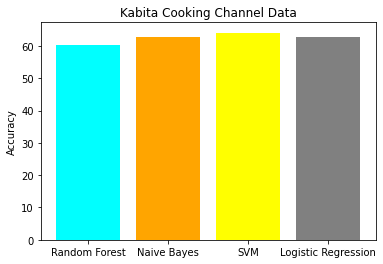

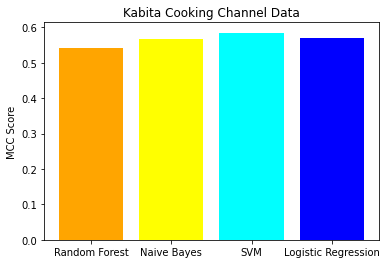

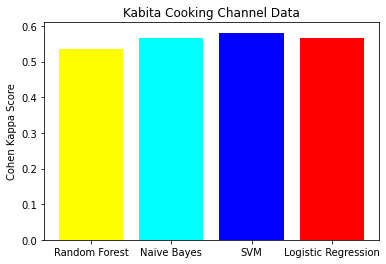

In [222]:
kabikit_acc = {'Random Forest':rf_k*100, 'Naive Bayes':nb_k*100, 'SVM':svm_k*100, 'Logistic Regression':lr_k*100}
nisha_acc = {'Random Forest':rf_n*100, 'Naive Bayes':nb_n*100, 'SVM':svm_n*100, 'Logistic Regression':lr_n*100}

kabikit_mcc = {'Random Forest':rf_k_mcc, 'Naive Bayes':nb_k_mmc, 'SVM': svm_k_mmc, 'Logistic Regression':lr_k_mcc}
nisha_mcc = {'Random Forest':rf_n_mcc, 'Naive Bayes':nb_n_mcc, 'SVM':svm_n_mcc, 'Logistic Regression':lr_n_mcc}

kabikit_k = {'Random Forest':rf_k_k, 'Naive Bayes':nb_k_k, 'SVM': svm_k_k, 'Logistic Regression':lr_k_k}
nisha_k = {'Random Forest':rf_n_k, 'Naive Bayes':nb_n_k, 'SVM':svm_n_k, 'Logistic Regression':lr_n_k}

plt.bar(x=kabikit_acc.keys(),height=kabikit_acc.values(), color=['cyan','orange','yellow','grey'])
plt.ylabel("Accuracy")
plt.title('Kabita Cooking Channel Data')
plt.show()

plt.bar(x=kabikit_mcc.keys(), height=kabikit_mcc.values(), color = ['orange','yellow','cyan','blue'])
plt.ylabel("MCC Score")
plt.title('Kabita Cooking Channel Data')
plt.show()

plt.bar(x=kabikit_k.keys(), height=kabikit_k.values(), color = ['yellow','cyan','blue','red'])
plt.ylabel("Cohen Kappa Score")
plt.title('Kabita Cooking Channel Data')
plt.show()

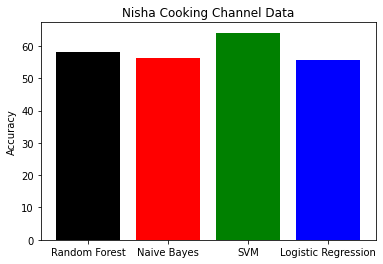

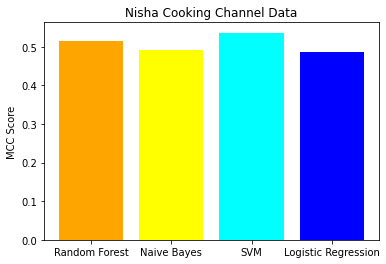

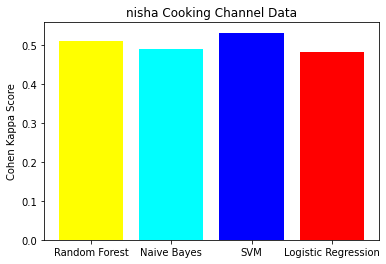

In [223]:
plt.bar(x=nisha_acc.keys(), height=nisha_acc.values(), color=['black','red','green','blue'])
plt.title('Nisha Cooking Channel Data')
plt.ylabel('Accuracy')
plt.show()

plt.bar(x=nisha_mcc.keys(), height=nisha_mcc.values(), color = ['orange','yellow','cyan','blue'])
plt.ylabel("MCC Score")
plt.title('Nisha Cooking Channel Data')
plt.show()

plt.bar(x=nisha_k.keys(), height=nisha_k.values(), color = ['yellow','cyan','blue','red'])
plt.ylabel("Cohen Kappa Score")
plt.title('nisha Cooking Channel Data')
plt.show()

Word2vec Transformation

In [224]:
text_k = [i.split() for i in kabikit['prep_text']]
wvmodel_k = Word2Vec(text_k, min_count=1, vector_size=100, epochs=20, window=3)
w2v_k = {}
for i in wvmodel_k.wv.index_to_key:
    w2v_k[i] = wvmodel_k.wv.get_vector(i)

In [225]:
text_n = [i.split() for i in nisha['prep_text']]
wvmodel_n = Word2Vec(text_n, min_count=1)
w2v_n = {}
for i in wvmodel_n.wv.index_to_key:
    w2v_k[i] = wvmodel_n.wv.get_vector(i)

In [226]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, w2v):
        self.word2vec = word2vec
        self.w2v = w2v
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = word2vec.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v.keys()]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [227]:
modelE = MeanEmbeddingVectorizer(wvmodel_k,w2v_k)
x_train_vec = modelE.transform([nltk.word_tokenize(i) for i in x_train])
x_test_vec = modelE.transform([nltk.word_tokenize(i) for i in x_test])

In [228]:
modelEN = MeanEmbeddingVectorizer(wvmodel_n,w2v_n)
x_train_vecn = modelEN.transform([nltk.word_tokenize(i) for i in x_train])
x_test_vecn = modelEN.transform([nltk.word_tokenize(i) for i in x_test])

Logistic Regression

In [229]:
#Kabita Data
lrk = LogisticRegression()
lrk.fit(x_train_vec,y_train)
y_pred = lrk.predict(x_test_vec)
print(classification_report(y_test, y_pred))
print("Logistic Regression Accuracy : ",accuracy_score(y_test,y_pred))
lr_vk = accuracy_score(y_test,y_pred)
lr_k_mcc = matthews_corrcoef(y_test,y_pred)
lr_k_k = cohen_kappa_score(y_test,y_pred)
lr_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.24      0.13      0.17       140
           1       0.27      0.61      0.37       140
           2       0.46      0.61      0.53       140
           3       0.55      0.04      0.08       140
           4       0.30      0.09      0.14       140
           5       0.33      0.58      0.42       140
           6       0.43      0.34      0.38       140

    accuracy                           0.34       980
   macro avg       0.37      0.34      0.30       980
weighted avg       0.37      0.34      0.30       980

Logistic Regression Accuracy :  0.34183673469387754


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [230]:
#Nisha Data
lrn = LogisticRegression()
lrn.fit(x_train_vecn,y_ntrain)
y_npred = lrn.predict(x_test_vecn)
print(classification_report(y_ntest, y_npred))
print("Logistic Regression Accuracy : ",accuracy_score(y_ntest,y_npred))
lr_vn = accuracy_score(y_ntest,y_npred)
lr_n_mcc = matthews_corrcoef(y_ntest,y_npred)
lr_n_k = cohen_kappa_score(y_ntest,y_npred)
lr_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.14      1.00      0.25       140
           1       0.00      0.00      0.00       140
           2       0.00      0.00      0.00       140
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       140
           5       0.00      0.00      0.00       140
           6       0.00      0.00      0.00       140

    accuracy                           0.14       980
   macro avg       0.02      0.14      0.04       980
weighted avg       0.02      0.14      0.04       980

Logistic Regression Accuracy :  0.14285714285714285


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Naive Bayes

In [231]:
#Kabita Data
nbv = GaussianNB()
nbv.fit(x_train_vec,y_train)
y_pred = nbv.predict(x_test_vec)
print(classification_report(y_test,y_pred))
nbv_vk = accuracy_score(y_test,y_pred)
nbv_k_mcc = matthews_corrcoef(y_test,y_pred)
nbv_k_k = cohen_kappa_score(y_test,y_pred)
nbv_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.28      0.19      0.23       140
           1       0.49      0.12      0.19       140
           2       0.75      0.46      0.57       140
           3       0.33      0.01      0.03       140
           4       0.23      0.52      0.32       140
           5       0.35      0.44      0.39       140
           6       0.27      0.53      0.36       140

    accuracy                           0.33       980
   macro avg       0.39      0.33      0.30       980
weighted avg       0.39      0.33      0.30       980



In [232]:
#Nisha Data
nbv = GaussianNB()
nbv.fit(x_train_vec,y_ntrain)
y_npred = nbv.predict(x_test_vecn)
print(classification_report(y_ntest,y_npred))
nbv_vn = accuracy_score(y_ntest,y_npred)
nbv_n_mcc = matthews_corrcoef(y_ntest,y_npred)
nbv_n_k = cohen_kappa_score(y_ntest,y_npred)
nbv_n_f1 = f1_score(y_ntest,y_npred, average='weighted')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       140
           2       0.00      0.00      0.00       140
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       140
           5       0.14      1.00      0.25       140
           6       0.00      0.00      0.00       140

    accuracy                           0.14       980
   macro avg       0.02      0.14      0.04       980
weighted avg       0.02      0.14      0.04       980



C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Random Forest Classifier

In [233]:
#kabita Data
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_vec,y_train)
y_pred = rf_clf.predict(x_test_vec)
print(classification_report(y_test, y_pred))
print("Random Forest Classifier Accuracy on kabikit : ",accuracy_score(y_test,y_pred))
rf_vk = accuracy_score(y_test,y_pred)
rf_k_mcc = matthews_corrcoef(y_test,y_pred)
rf_k_k = cohen_kappa_score(y_test,y_pred)
rf_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.44      0.37      0.40       140
           1       0.64      0.55      0.59       140
           2       0.93      0.80      0.86       140
           3       0.46      0.48      0.47       140
           4       0.33      0.44      0.38       140
           5       0.40      0.41      0.40       140
           6       0.49      0.52      0.51       140

    accuracy                           0.51       980
   macro avg       0.53      0.51      0.52       980
weighted avg       0.53      0.51      0.52       980

Random Forest Classifier Accuracy on kabikit :  0.5091836734693878


In [234]:
#Nisha Data
rf_clfn = RandomForestClassifier()
rf_clfn.fit(x_train_vecn,y_ntrain)
y_npred = rf_clfn.predict(x_test_vecn)
print(classification_report(y_ntest, y_npred))
print("Random Forest Classifier Accuracy on nisha : ",accuracy_score(y_ntest,y_npred))
rf_vn = accuracy_score(y_ntest,y_npred)
rf_n_mcc = matthews_corrcoef(y_ntest,y_npred)
rf_n_k = cohen_kappa_score(y_ntest,y_npred)
rf_n_f1 = f1_score(y_ntest,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.14      1.00      0.25       140
           1       0.00      0.00      0.00       140
           2       0.00      0.00      0.00       140
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       140
           5       0.00      0.00      0.00       140
           6       0.00      0.00      0.00       140

    accuracy                           0.14       980
   macro avg       0.02      0.14      0.04       980
weighted avg       0.02      0.14      0.04       980

Random Forest Classifier Accuracy on nisha :  0.14285714285714285


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

SVM Model

In [235]:
#Kabita Data
svm_clf = svm.SVC()
svm_clf.fit(x_train_vec,y_train)
y_pred = svm_clf.predict(x_test_vec)
print(classification_report(y_test, y_pred))
print("svm Accuracy on kabikit : ", accuracy_score(y_test,y_pred))
svm_vk = accuracy_score(y_test,y_pred)
svm_k_mcc = matthews_corrcoef(y_test,y_pred)
svm_k_k = cohen_kappa_score(y_test,y_pred)
svm_k_f1 = f1_score(y_test,y_pred, average='weighted')

              precision    recall  f1-score   support

           0       0.45      0.12      0.19       140
           1       0.25      0.61      0.36       140
           2       0.76      0.59      0.66       140
           3       0.10      0.01      0.02       140
           4       0.37      0.21      0.27       140
           5       0.37      0.50      0.42       140
           6       0.35      0.51      0.42       140

    accuracy                           0.37       980
   macro avg       0.38      0.37      0.34       980
weighted avg       0.38      0.37      0.34       980

svm Accuracy on kabikit :  0.3663265306122449


In [236]:
#Nisha Data
svm_clfn = svm.SVC()
svm_clfn.fit(x_train_vecn,y_ntrain)
y_npred = svm_clfn.predict(x_test_vecn)
print(classification_report(y_ntest, y_npred))
print("svm Accuracy on nisha : ", accuracy_score(y_ntest,y_npred))
svm_vn = accuracy_score(y_ntest,y_npred)
rf_n_mcc = matthews_corrcoef(y_ntest,y_npred)
rf_n_k = cohen_kappa_score(y_ntest,y_npred)
rf_n_f1 = f1_score(y_ntest,y_npred, average='weighted')
print(rf_n_k)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       140
           2       0.00      0.00      0.00       140
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       140
           5       0.00      0.00      0.00       140
           6       0.14      1.00      0.25       140

    accuracy                           0.14       980
   macro avg       0.02      0.14      0.04       980
weighted avg       0.02      0.14      0.04       980

svm Accuracy on nisha :  0.14285714285714285
0.0


C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Evaluation of Word2vec

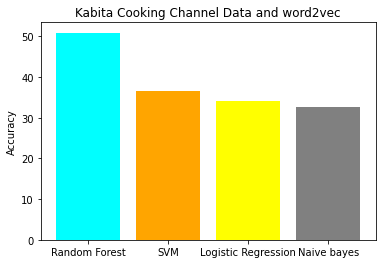

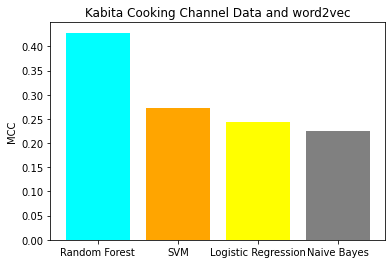

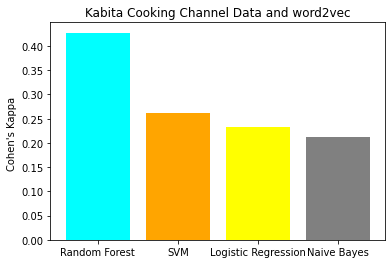

In [237]:
kabikit_vacc = {'Random Forest':rf_vk*100, 'SVM':svm_vk*100, 'Logistic Regression':lr_vk*100, 'Naive bayes':nbv_vk*100}
nisha_vacc = {'Random Forest':rf_vn*100, 'SVM':svm_vn*100, 'Logistic Regression':lr_vn*100, 'Naive bayes':nbv_vn*100}

kabikit_vmcc = {'Random Forest':rf_k_mcc, 'SVM':svm_k_mcc, 'Logistic Regression':lr_k_mcc, 'Naive Bayes':nbv_k_mcc}
nisha_vmcc = {'Random Forest':rf_n_mcc, 'SVM':svm_n_mcc, 'Logistic Regression':lr_n_mcc, 'Naive Bayes':nbv_n_mcc}

kabikit_vk = {'Random Forest':rf_k_k, 'SVM':svm_k_k, 'Logistic Regression':lr_k_k, 'Naive Bayes':nbv_k_k}
nisha_vk = {'Random Forest':rf_n_k, 'SVM':svm_n_k, 'Logistic Regression':lr_n_k, 'Naive Bayes':nbv_n_k}


plt.bar(x=kabikit_vacc.keys(),height=kabikit_vacc.values(), color=['cyan','orange','yellow','grey'])
plt.ylabel("Accuracy")
plt.title('Kabita Cooking Channel Data and word2vec')
plt.show()

plt.bar(x=kabikit_vmcc.keys(),height=kabikit_vmcc.values(), color=['cyan','orange','yellow','grey'])
plt.ylabel("MCC")
plt.title('Kabita Cooking Channel Data and word2vec')
plt.show()

plt.bar(x=kabikit_vk.keys(),height=kabikit_vk.values(), color=['cyan','orange','yellow','grey'])
plt.ylabel("Cohen's Kappa ")
plt.title('Kabita Cooking Channel Data and word2vec')
plt.show()

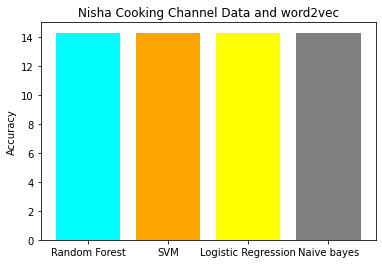

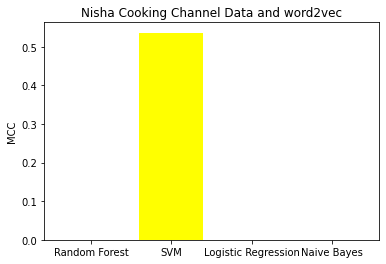

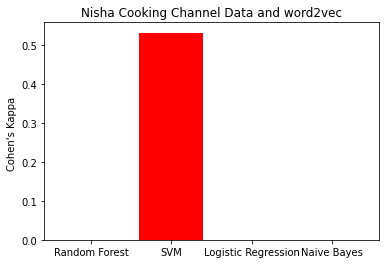

In [238]:
plt.bar(x=nisha_vacc.keys(),height=nisha_vacc.values(), color=['cyan','orange','yellow','grey'])
plt.ylabel("Accuracy")
plt.title('Nisha Cooking Channel Data and word2vec')
plt.show()

plt.bar(x=nisha_vmcc.keys(),height=nisha_vmcc.values(), color=['orange','yellow','grey','red'])
plt.ylabel("MCC")
plt.title('Nisha Cooking Channel Data and word2vec')
plt.show()

plt.bar(x=nisha_vk.keys(),height=nisha_vk.values(), color=['cyan','red','grey','brown'])
plt.ylabel("Cohen's Kappa ")
plt.title('Nisha Cooking Channel Data and word2vec')
plt.show()